In [139]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
df=pd.read_csv('data.csv', encoding='ISO-8859-1')

In [141]:
# Assuming df is your original dataset
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Ensure InvoiceDate is in datetime format

In [142]:
df=df[df['UnitPrice']>0 ]

In [143]:
# Remove rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

In [144]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [145]:
# Calculate Total Spending (Monetary)
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

In [146]:
# Recency - days since last purchase
# First, find the most recent date in the dataset
max_date = df['InvoiceDate'].max()

# Calculate recency for each customer
customer_recency = df.groupby('CustomerID')['InvoiceDate'].max()  # Most recent purchase date per customer
customer_recency = (max_date - customer_recency).dt.days  # Calculate days since last purchase

In [147]:
customer_recency.head(100)

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
          ... 
12462.0      1
12463.0     45
12464.0      9
12465.0      7
12468.0    142
Name: InvoiceDate, Length: 100, dtype: int64

In [148]:
# Frequency - number of unique invoices per customer
customer_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()  # Count unique invoices per customer

In [149]:
# Monetary - total spending for each customer
customer_monetary = df.groupby('CustomerID')['TotalSpend'].sum()  # Sum of total spending for each customer

In [150]:
# Combine all the features into a single DataFrame
customer_features = pd.DataFrame({
    'CustomerID': customer_recency.index,
    'Recency': customer_recency.values,
    'Frequency': customer_frequency.values,
    'Monetary': customer_monetary.values
})

In [151]:
customer_features['CustomerID'] = customer_features['CustomerID'].astype(int).astype(str)

In [152]:
# Display the first few rows of the customer-level features
print(customer_features.head())

  CustomerID  Recency  Frequency  Monetary
0      12346      325          2      0.00
1      12347        1          7   4310.00
2      12348       74          4   1797.24
3      12349       18          1   1757.55
4      12350      309          1    334.40


In [153]:
nan_rows = customer_features[customer_features.isnull().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [CustomerID, Recency, Frequency, Monetary]
Index: []


In [154]:
# Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(customer_features)

In [155]:
df_scaled.shape

(4371, 4)

In [156]:
# Elbow Method to Find Optimal Number of Clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

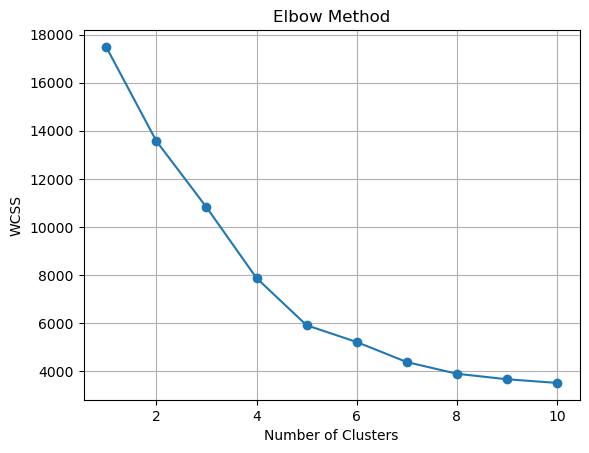

In [157]:
# Plot the elbow method graph to determine the optimal number of clusters
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [158]:
# Based on the elbow plot, assume the optimal number of clusters is 4
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters,random_state=42)


In [159]:
# Step 4: Apply KMeans clustering and assign clusters to the data
customer_features['cluster']= kmeans.fit_predict(df_scaled)

In [160]:
customer_features.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346,325,2,0.00,0
1,12347,1,7,4310.00,2
2,12348,74,4,1797.24,2
3,12349,18,1,1757.55,2
4,12350,309,1,334.40,0


In [161]:
customer_features['CustomerID'] = customer_features['CustomerID'].astype(int)
df['CustomerID'] = df['CustomerID'].astype(int)

# You can merge the cluster assignments back into the original dataframe
df = df.merge(customer_features[['CustomerID', 'cluster', 'Recency', 'Frequency','Monetary']], on='CustomerID', how='left')

In [162]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,cluster,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,0,301,35,5288.63
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,0,301,35,5288.63
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,0,301,35,5288.63
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,0,301,35,5288.63
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,0,301,35,5288.63


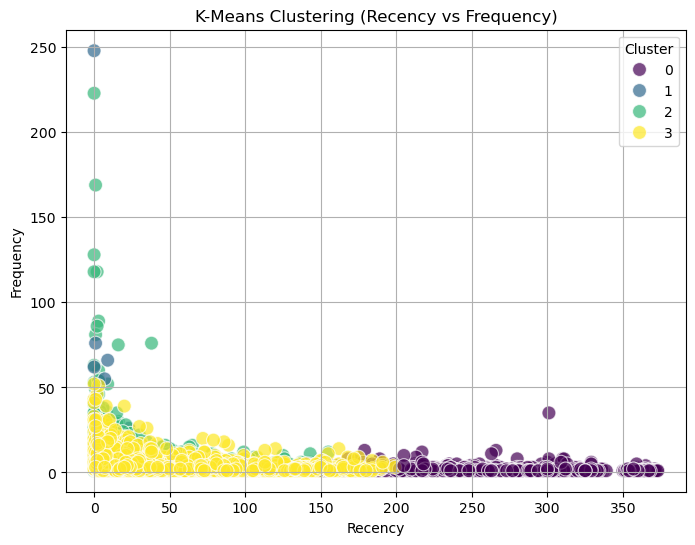

In [163]:
# Step 4: Apply KMeans clustering and assign clusters to the data
customer_features['cluster']= kmeans.fit_predict(df_scaled)# Scatter plot of Recency vs Frequency, colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_features['Recency'],
    y=customer_features['Frequency'],
    hue=customer_features['cluster'],
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('K-Means Clustering (Recency vs Frequency)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [164]:
# Create a new sample data row
new_data = pd.DataFrame({
    'CustomerID': ['99999'],
    'Recency': [10],  # Example recency value
    'Frequency': [5],  # Example frequency value
    'Monetary': [500]  # Example monetary value
})

# Drop the CustomerID column for scaling
#new_data_features = new_data.drop(columns=['CustomerID'])

# Scale the new data row using the same scaler
new_data_scaled = scaler.transform(new_data)


# Predict the cluster for the new data row
new_data['cluster'] = kmeans.predict(new_data_scaled)

print(new_data)

  CustomerID  Recency  Frequency  Monetary  cluster
0      99999       10          5       500        3


In [165]:
# Save DataFrame to CSV
df.to_csv('output.csv', index=False)